In [41]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from palmerpenguins import load_penguins

In [ ]:
peng = load_penguins()

In [107]:
peng_orig = load_penguins()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

#### Pre-processing data
* Using pd.factorize(), transform the categorical variables into numbers.
* Afterward, impute the missing values for each column by the mean.
* Then, using train_test_split, generate a 80-20 split

In [91]:
## Check var types
print(f'Variable types:\n{peng.dtypes}')
print('')

## Factorize to convert to categorical type
peng[['species', 'island', 'sex']] = peng[['species', 'island', 'sex']].apply(lambda x: pd.factorize(x)[0])

## Check NAs for each variable
print(f'NA counts by feature:\n{peng.isna().sum()}')
print('')

## Impute NAs w/mean and then check to make sure it worked n all that 
peng.fillna(peng.mean(), inplace=True)
print(f'Updated NA counts by feature:\n{peng.isna().sum()}')

Variable types:
species                int64
island                 int64
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                    int64
year                   int64
dtype: object

NA counts by feature:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
year                 0
dtype: int64

Updated NA counts by feature:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
year                 0
dtype: int64


In [149]:
## Create y and X
y = peng['species']
X = peng.drop(columns = ['species']).reset_index(drop = True)

## Create train, test split  
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## Fit scaler 
scaler = StandardScaler() ## will put our data on normal scale --> impt for gradient descent convergence 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## convert to numpy arrays to fix error w df 
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


## Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [152]:
## Define model
class penguinNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(penguinNet, self).__init__()

        ## Set up our dense layer -- which will connect each input feature to hidden layer 
        self.linear1 = nn.Linear(input_size, hidden_size) 

        ## Set up 2nd linear layer, which will output a vector of size = number of classes (3, for 3 species)
        self.linear2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        ## Pass our predictors through the linear layer ... input_size -> hidden_size
        out = self.linear1(x)
        ## Now pass the above through our non-linear layer 
        out = F.relu(out)
        ## Run the above through our 2nd linear layer and map to the number of classes (3) we are looking at.... hidden_size -> output_size, 3 classes 
        out = self.linear2(out)  

        ## return the raw scores 
        return out 



In [153]:
## Number of features 
input_size = 7
## Number of hidden layers 
hidden_size = 16  
## Out output 
output_size = 3  

## Run model 
model = penguinNet(input_size, hidden_size, output_size)

## Find loss 
criterion = nn.CrossEntropyLoss() 

## Set up Adam optimizer to update the weights with learning rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)  

num_epochs = 100
for epoch in range(num_epochs):
    ## Set to training mode 
    model.train() 

    ## Pass data thru the model 
    predictions = model(X_train_tensor)

    ## Calculate how far off we were 
    loss = criterion(predictions, y_train_tensor)

    ## not sure what this line does actually 
    optimizer.zero_grad()  

    ## Find loss gradient 
    loss.backward()  

    ## Update the weights 
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/100], Loss: 0.8929
Epoch [10/100], Loss: 0.6598
Epoch [15/100], Loss: 0.4618
Epoch [20/100], Loss: 0.3041
Epoch [25/100], Loss: 0.1906
Epoch [30/100], Loss: 0.1179
Epoch [35/100], Loss: 0.0773
Epoch [40/100], Loss: 0.0551
Epoch [45/100], Loss: 0.0419
Epoch [50/100], Loss: 0.0339
Epoch [55/100], Loss: 0.0287
Epoch [60/100], Loss: 0.0247
Epoch [65/100], Loss: 0.0216
Epoch [70/100], Loss: 0.0192
Epoch [75/100], Loss: 0.0173
Epoch [80/100], Loss: 0.0157
Epoch [85/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0133
Epoch [95/100], Loss: 0.0125
Epoch [100/100], Loss: 0.0118


#### Run this to evaluate your model!

In [154]:
with torch.no_grad():
    ## Forward pass on the test set
    outputs = model(X_test_tensor)
    
    ## Get predicted classes
    _, ypred = torch.max(outputs, 1)
    
    ## Calculate accuracy
    total = y_test_tensor.size(0)
    correct = (ypred == y_test_tensor).sum().item()
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


### Generate a confusion matrix of the classifications

Performance Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        11

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



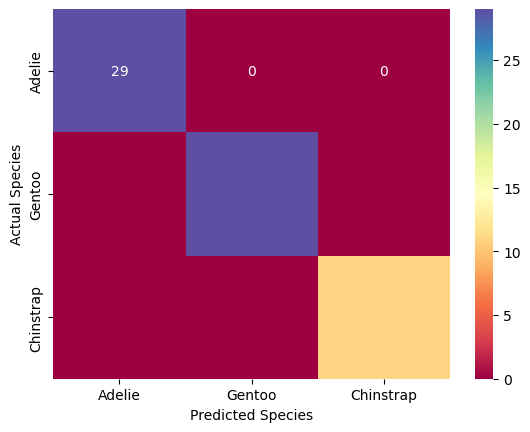

In [156]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Look at all our performance metrics at once 
print("Performance Report:\n", classification_report(y_test, ypred))

## Make the confusion matrix 
confusion_model = confusion_matrix(y_test, ypred)

## Plot the above 
sns.heatmap(confusion_model, annot=True, fmt='d', 
              cmap='Spectral',
            xticklabels=list(peng_orig.species.unique()),  
            yticklabels=list(peng_orig.species.unique()))
plt.xlabel('Predicted Species')
plt.ylabel('Actual Species')
plt.show()


# Word2Vec: The Prehistoric LLM

In [157]:
# Import libraries
import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [158]:
# Download necessary NLTK data files
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/vicmoreno/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vicmoreno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [141]:
# Load and preprocess the data
sentences = []
for fileid in reuters.fileids():
    words = reuters.words(fileid)
    sentences.append([word.lower() for word in words if word.isalpha()])

# # Display a few example sentences
# print("Example sentences:")
# for i in range(2):
#     print(sentences[i])

In [160]:
# Define and train the Word2Vec model
model = Word2Vec(sentences, vector_size=40, 
                 window=5, 
                 min_count=5, 
                 sg=1, 
                 epochs=100)

# # Display vocabulary size
# print("Vocabulary size:", len(model.wv))

In [ ]:
# Finding words similar to 'market'
similar_words = model.wv.most_similar('market', topn=10)
print("Words similar to 'market':")

for word, score in similar_words:
    print(f"{word}: {score}")

In [ ]:
# Choose a subset of words for visualization
words = ['market', 'economy', 'trade', 'finance', 'investment', 'growth', 'bank', 'money', 'stocks', 'currency']
word_vectors = np.array([model.wv[word] 
                         for w in words 
                         if w in model.wv])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=2,)
word_vectors_2d = tsne.fit_transform(word_vectors)



In [ ]:
# Plot the words and their vectors
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# Annotate each point with the word
for i, word in enumerate(words):
    if word in model.wv:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("Word Embedding Visualization with t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")



## Exploring word2vec
* First, use two of your favorite word and identify the top 40 similar words.
* Then transform those words into vectors.
* Using Principal component analysis, plot the 80 words using MatPlotLib, coloring the two word groups differently


In [165]:
# Finding words similar to 'market'
similar_words = model.wv.most_similar('hunger', topn=10)
print("Words similar to 'hunger':")

for word, score in similar_words:
    print(f"{word}: {score}")

Words similar to 'hunger':
strike: 0.7807148098945618
lechin: 0.7494771480560303
launch: 0.7262098789215088
dockworkers: 0.6960565447807312
workers: 0.6929803490638733
stoppage: 0.6800636649131775
strikes: 0.672353982925415
miners: 0.6704554557800293
guided: 0.6676190495491028
comibol: 0.6662057042121887


In [166]:
# Plot the words and their vectors
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# Annotate each point with the word
for i, word in enumerate(words):
    if word in model.wv:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("Word Embedding Visualization with t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")



NameError: name 'word_vectors_2d' is not defined

<Figure size 1000x800 with 0 Axes>